In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from deap import base, creator, tools, algorithms
import random
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("final_processed_data.csv", low_memory=False)

# Define features to exclude (blacklist)
blacklist_features = ['EUR', 'TOTAL_PRICE', 'PRICE_PER_KM']

# Prepare feature matrix X and target variable y
X = df.drop(columns=blacklist_features)
y = df['TOTAL_PRICE']

# Define TimeSeries cross-validation (5 splits)
outer_cv = TimeSeriesSplit(n_splits=5)

# Parameters for the genetic algorithm (GA)
num_features = X.shape[1]
population_size = 20
num_generations = 10

# Initialize DEAP for evolutionary feature selection
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define fitness evaluation function (minimizing MAPE)
def evalFitness(individual, X_train, y_train, X_valid, y_valid):
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_indices) == 0:
        return 1e6,  # Penalty for no features selected

    X_tr_sel = X_train.iloc[:, selected_indices]
    X_val_sel = X_valid.iloc[:, selected_indices]

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_tr_sel, y_train)
    preds = model.predict(X_val_sel)
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mape,

toolbox.register("evaluate", evalFitness, X_train=None, y_train=None, X_valid=None, y_valid=None)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# List to store MAPE scores for each fold
mape_scores = []

fold_number = 1
# Outer cross-validation loop (time series approach)
for train_index, test_index in outer_cv.split(X):
    print(f"\nProcessing Fold {fold_number}...")

    # Splitting dataset into train and test respecting chronological order
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Inner CV for feature selection using GA (nested TimeSeriesSplit)
    inner_cv = TimeSeriesSplit(n_splits=3)
    
    def fitness_wrapper(individual):
        inner_scores = []
        # Nested CV loop for robust evaluation of feature subsets
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
            X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]
            
            score = evalFitness(individual, X_inner_train, y_inner_train, X_inner_val, y_inner_val)[0]
            inner_scores.append(score)
        return np.mean(inner_scores),

    toolbox.register("evaluate", fitness_wrapper)

    # Run the Genetic Algorithm (GA)
    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, verbose=False)

    # Select the best feature subset from GA
    best_individual = tools.selBest(population, 1)[0]
    selected_features_idx = [i for i, bit in enumerate(best_individual) if bit == 1]
    selected_feature_names = X.columns[selected_features_idx]

    print(f"Fold {fold_number}: Selected {len(selected_feature_names)} features")

    # Final evaluation on the outer test set
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train.iloc[:, selected_features_idx], y_train)
    y_pred = model.predict(X_test.iloc[:, selected_features_idx])
    fold_mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Fold {fold_number}: MAPE = {fold_mape:.4f}")

    mape_scores.append(fold_mape)
    fold_number += 1

# Display cross-validation results
print("\nCross-validation results (TimeSeriesSplit):")
for i, score in enumerate(mape_scores, 1):
    print(f"Fold {i}: MAPE = {score:.4f}")

print(f"\nAverage MAPE across folds: {np.mean(mape_scores):.4f}")



Processing Fold 1...
Fold 1: Selected 33 features
Fold 1: MAPE = 0.0819

Processing Fold 2...
Fold 2: Selected 32 features
Fold 2: MAPE = 0.0902

Processing Fold 3...
Fold 3: Selected 25 features
Fold 3: MAPE = 0.0874

Processing Fold 4...
Fold 4: Selected 30 features
Fold 4: MAPE = 0.0734

Processing Fold 5...
Fold 5: Selected 24 features
Fold 5: MAPE = 0.0692

Cross-validation results (TimeSeriesSplit):
Fold 1: MAPE = 0.0819
Fold 2: MAPE = 0.0902
Fold 3: MAPE = 0.0874
Fold 4: MAPE = 0.0734
Fold 5: MAPE = 0.0692

Average MAPE across folds: 0.0804


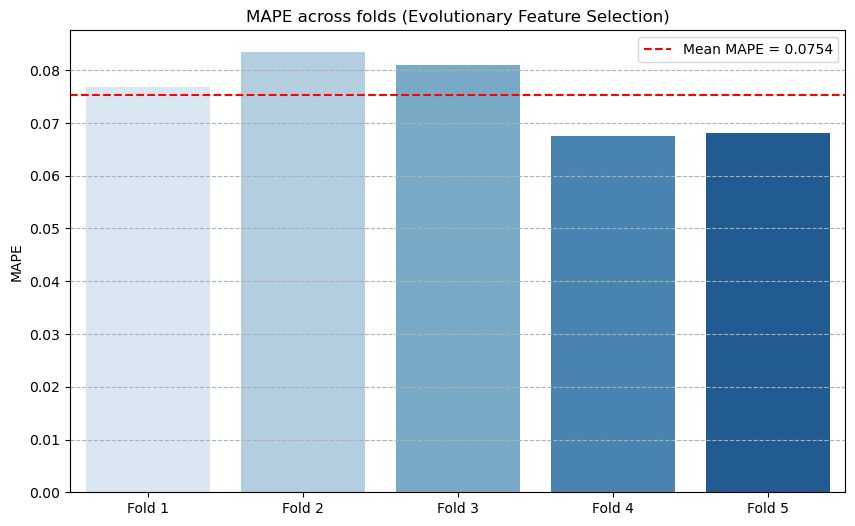

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

mape_scores = [0.0768, 0.0834, 0.0809, 0.0676, 0.0681]
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

plt.figure(figsize=(10,6))
sns.barplot(x=folds, y=mape_scores, palette='Blues')
plt.axhline(np.mean(mape_scores), color='red', linestyle='--', label=f'Mean MAPE = {np.mean(mape_scores):.4f}')
plt.ylabel('MAPE')
plt.title('MAPE across folds (Evolutionary Feature Selection)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()


Analyzing selected features for Fold 1...
Fold 1: 29 features selected.

Analyzing selected features for Fold 2...
Fold 2: 27 features selected.

Analyzing selected features for Fold 3...
Fold 3: 29 features selected.

Analyzing selected features for Fold 4...
Fold 4: 26 features selected.

Analyzing selected features for Fold 5...
Fold 5: 30 features selected.


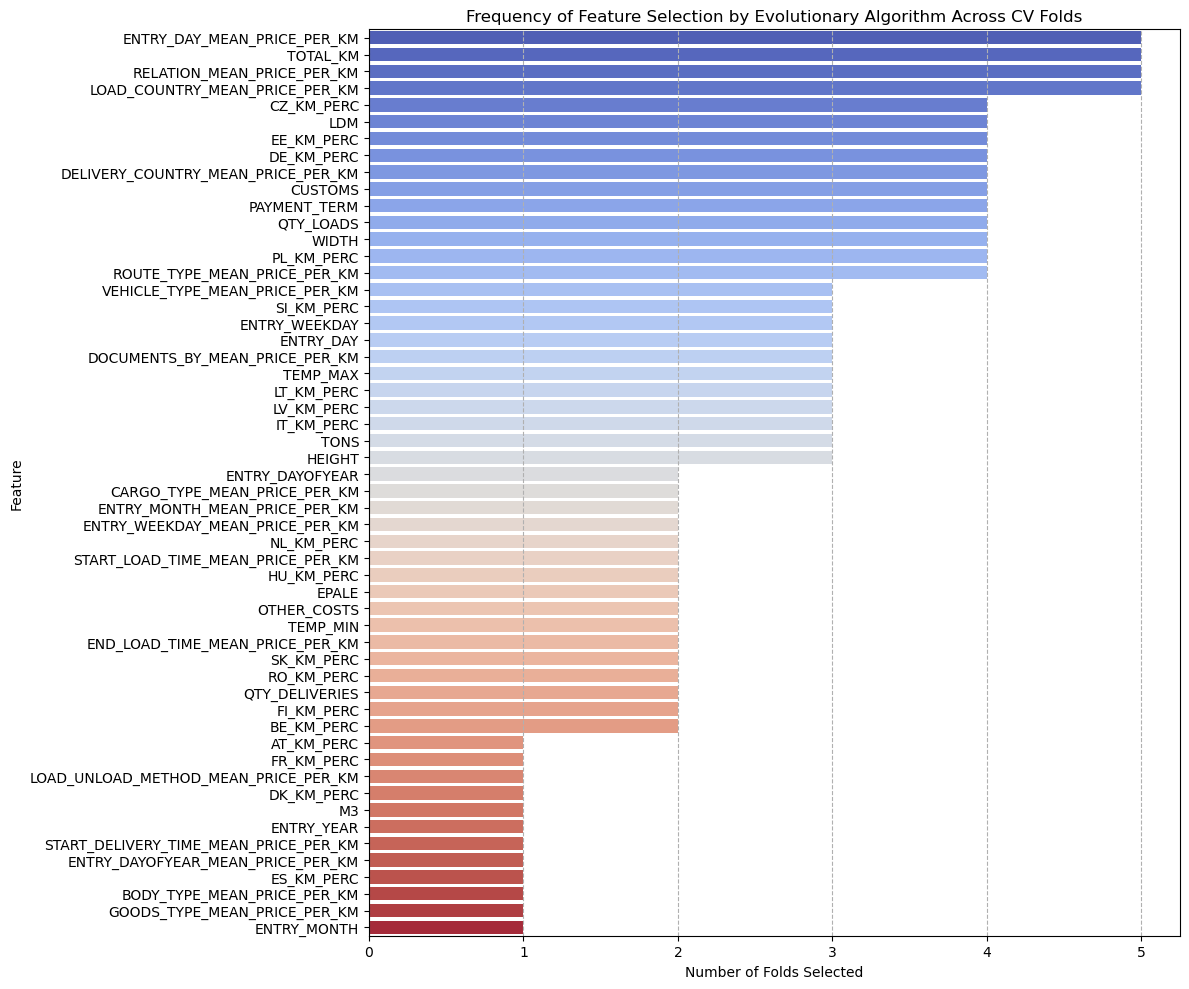


Feature Selection Frequency Across Folds:
                                  Feature  Selection_Count
0             ENTRY_DAY_MEAN_PRICE_PER_KM                5
1                                TOTAL_KM                5
2              RELATION_MEAN_PRICE_PER_KM                5
3          LOAD_COUNTRY_MEAN_PRICE_PER_KM                5
4                              CZ_KM_PERC                4
5                                     LDM                4
6                              EE_KM_PERC                4
7                              DE_KM_PERC                4
8      DELIVERY_COUNTRY_MEAN_PRICE_PER_KM                4
9                                 CUSTOMS                4
10                           PAYMENT_TERM                4
11                              QTY_LOADS                4
12                                  WIDTH                4
13                             PL_KM_PERC                4
14           ROUTE_TYPE_MEAN_PRICE_PER_KM                4
15         VE

In [3]:
# Cell 2: Analysis and visualization of features selected across folds

# Import additional required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Re-initialize TimeSeriesSplit for reproducibility
outer_cv = TimeSeriesSplit(n_splits=5)

# Prepare a list to store selected features from each fold
selected_features_folds = []

fold_number = 1
# Outer cross-validation loop to collect selected features
for train_index, test_index in outer_cv.split(X):
    print(f"\nAnalyzing selected features for Fold {fold_number}...")

    # Splitting dataset into train and test respecting chronological order
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Inner CV for evolutionary feature selection (nested TimeSeriesSplit)
    inner_cv = TimeSeriesSplit(n_splits=3)

    def fitness_wrapper(individual):
        inner_scores = []
        # Evaluate the feature subset using inner nested CV
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
            X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

            score = evalFitness(individual, X_inner_train, y_inner_train, X_inner_val, y_inner_val)[0]
            inner_scores.append(score)
        return np.mean(inner_scores),

    toolbox.register("evaluate", fitness_wrapper)

    # Run Genetic Algorithm (GA) to select best feature subset
    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, verbose=False)

    # Select the best individual and retrieve corresponding features
    best_individual = tools.selBest(population, 1)[0]
    selected_features_idx = [i for i, bit in enumerate(best_individual) if bit == 1]
    selected_feature_names = X.columns[selected_features_idx]

    # Save selected features for the current fold
    selected_features_folds.append(selected_feature_names.tolist())

    print(f"Fold {fold_number}: {len(selected_feature_names)} features selected.")
    fold_number += 1

# After collecting selected features from all folds, calculate feature selection frequencies
feature_counts = Counter([feature for fold_features in selected_features_folds for feature in fold_features])

# Create DataFrame for easier analysis
feature_counts_df = pd.DataFrame(feature_counts.items(), columns=['Feature', 'Selection_Count']).sort_values(by='Selection_Count', ascending=False)

# Plot the frequency of feature selection across folds
plt.figure(figsize=(12, 10))
sns.barplot(x='Selection_Count', y='Feature', data=feature_counts_df, palette='coolwarm')

# Plot configuration
plt.xlabel('Number of Folds Selected')
plt.ylabel('Feature')
plt.title('Frequency of Feature Selection by Evolutionary Algorithm Across CV Folds')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()

# Display the plot
plt.show()

# Show summary table
print("\nFeature Selection Frequency Across Folds:")
print(feature_counts_df.reset_index(drop=True))


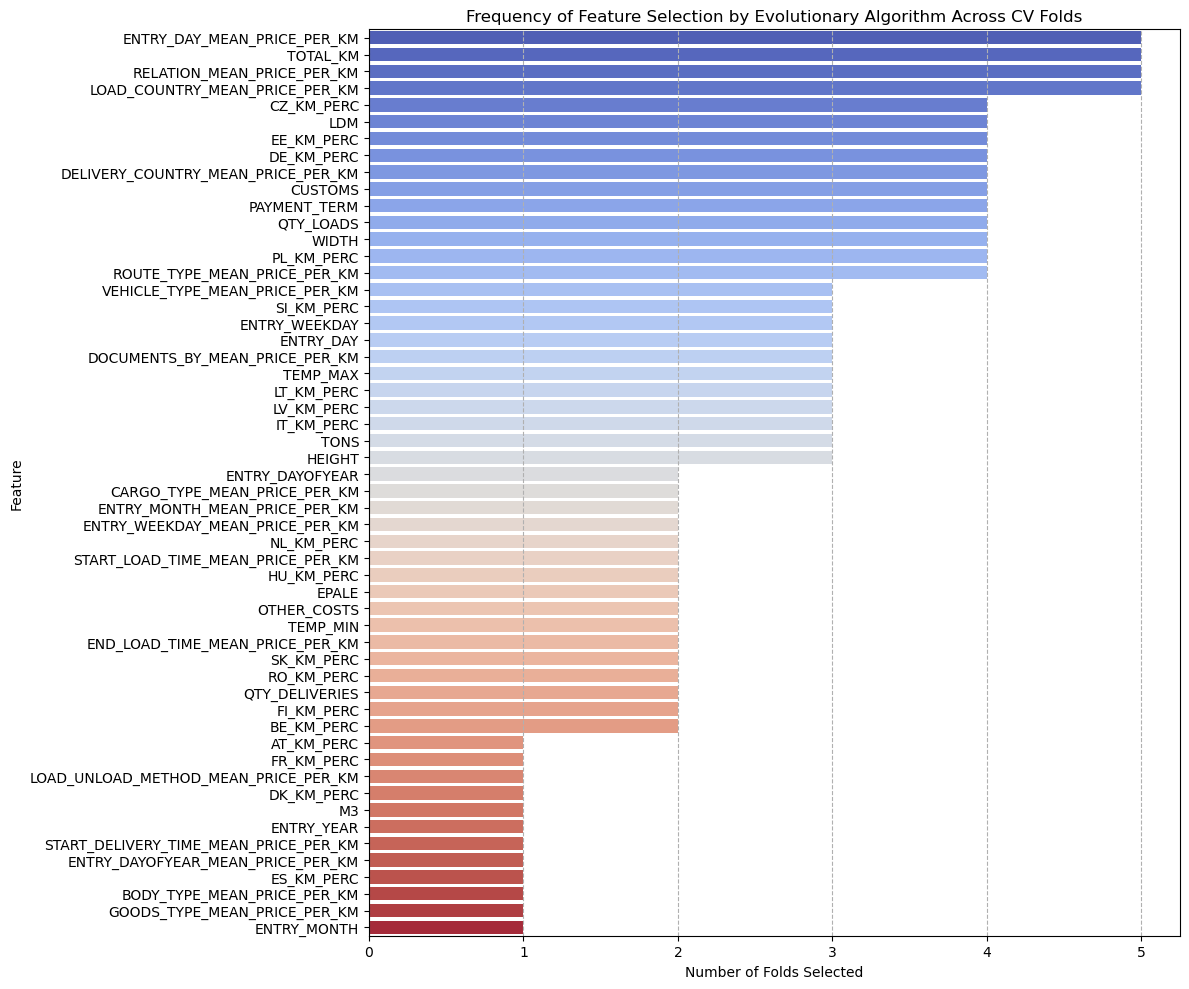

In [4]:
# Plot the frequency of feature selection across folds
plt.figure(figsize=(12, 10))
sns.barplot(x='Selection_Count', y='Feature', data=feature_counts_df, palette='coolwarm')

# Plot configuration
plt.xlabel('Number of Folds Selected')
plt.ylabel('Feature')
plt.title('Frequency of Feature Selection by Evolutionary Algorithm Across CV Folds')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()

# Display the plot
plt.show()